In [3]:
import sys
sys.path.append("..")

import dataInterpreter as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import adjusted_rand_score

In [4]:
data = dt.get_data('A549', 'healthy', 'sars-cov2', series = (2, 5))
columns_healthy = dt.get_columns('A549', 'healthy', series = (2, 5))
columns_sars_cov2 = dt.get_columns('A549', 'sars-cov2', series = (2, 5))

filtered_data = dt.get_p_values('mannwhitneyu', data, columns_healthy, columns_sars_cov2, limit = 0.01)
filtered_data

,Series2_A549_Mock_1,Series2_A549_Mock_2,Series2_A549_Mock_3,Series2_A549_SARS-CoV-2_1,Series2_A549_SARS-CoV-2_2,Series2_A549_SARS-CoV-2_3,Series5_A549_Mock_1,Series5_A549_Mock_2,Series5_A549_Mock_3,Series5_A549_SARS-CoV-2_1,Series5_A549_SARS-CoV-2_2,Series5_A549_SARS-CoV-2_3,p-value
TNFRSF9,4.454347,3.583519,3.135494,4.584967,4.330733,4.174387,3.806662,3.951244,3.784190,5.370638,5.497168,5.966147,0.006533
ERRFI1,7.648263,7.075809,6.801283,8.130942,7.842671,7.553287,7.469084,7.460490,7.387090,8.114025,9.015784,8.671630,0.004120
PIK3CD,5.863631,5.370638,5.093750,6.011267,6.016157,5.774552,5.872118,5.683580,5.659482,6.259581,6.505784,6.955593,0.006533
NMNAT1,4.962845,4.430817,4.143135,5.361292,4.919981,4.804021,4.672829,4.753590,4.753590,5.111988,5.023881,5.726848,0.006453
RBP7,3.465736,2.890372,1.791759,3.970292,4.189655,3.465736,3.496508,3.401197,3.555348,4.007333,4.174387,4.997212,0.008061
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMEM255A,0.693147,0.693147,0.693147,1.945910,2.079442,1.098612,1.098612,1.386294,1.791759,2.079442,3.218876,3.044522,0.007601
LINC00629,1.609438,1.098612,1.098612,2.079442,2.397895,1.791759,2.079442,1.386294,2.079442,2.484907,2.197225,3.555348,0.009579
FHL1,6.298949,5.652489,5.455321,6.687109,6.453625,6.324359,6.196444,6.298949,6.082219,6.984716,7.044905,7.576097,0.002499
L1CAM,5.389072,5.030438,4.543295,5.552960,5.484797,5.164786,5.062595,4.976734,4.955827,6.161207,6.603944,7.064759,0.004120


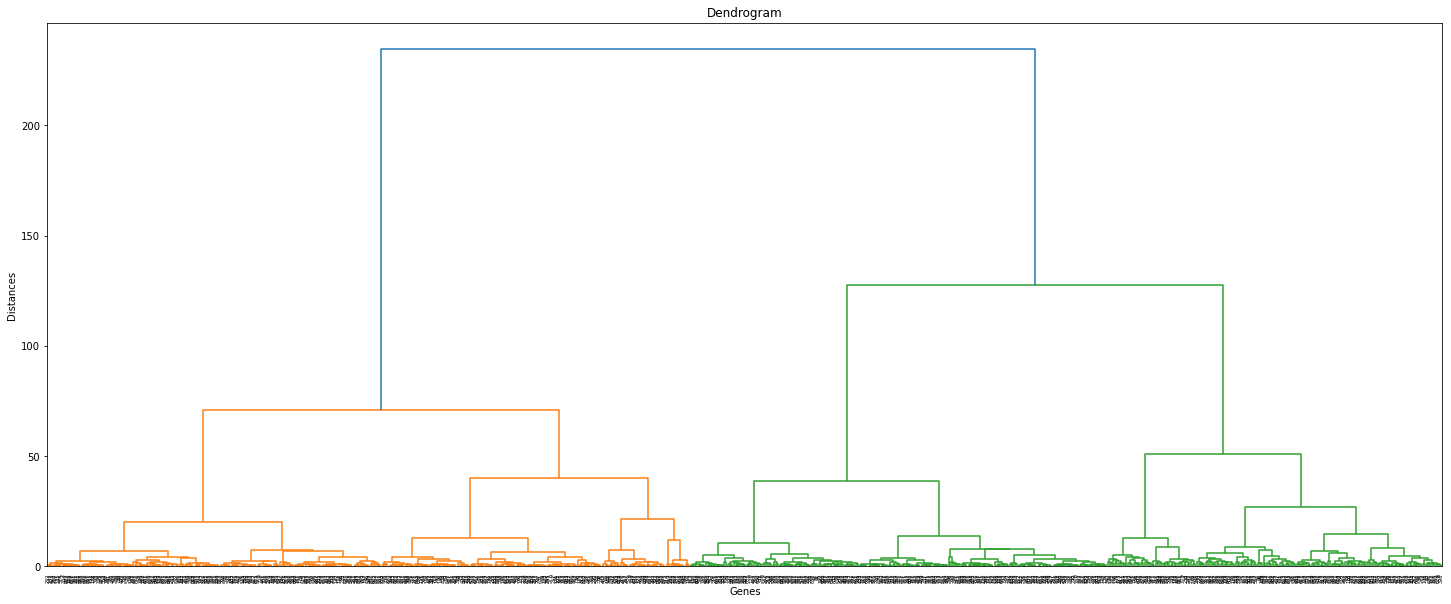

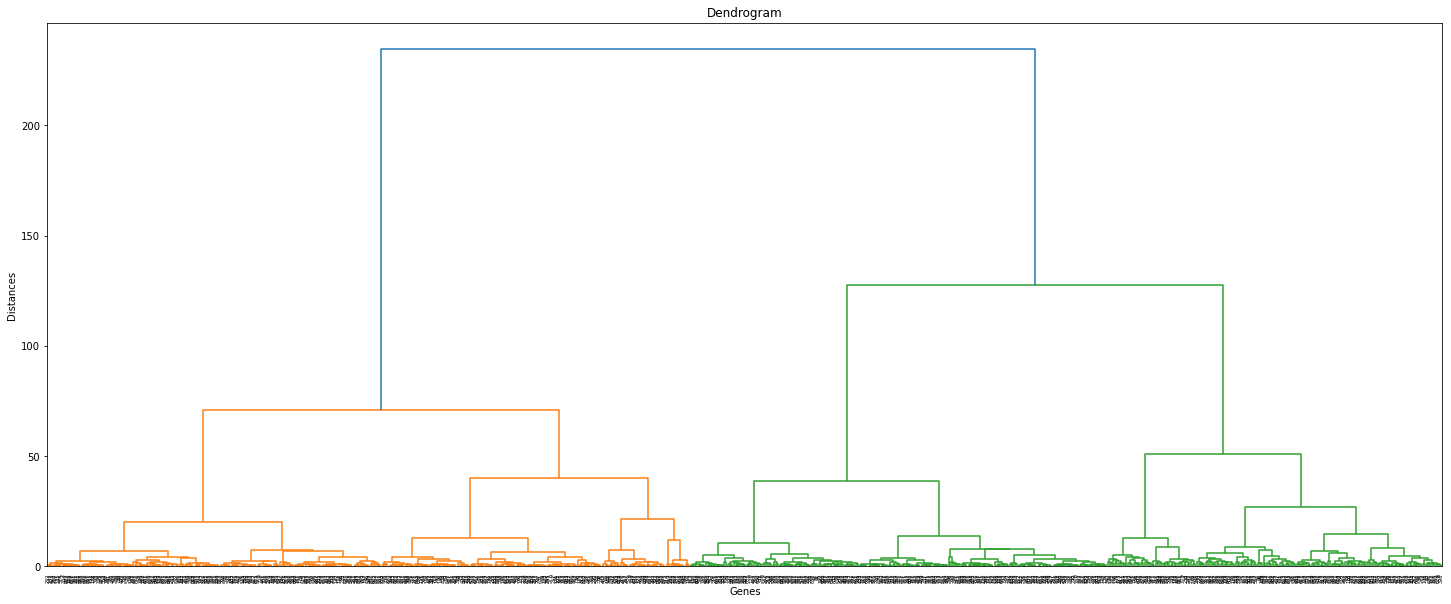

In [5]:
filtered_data.drop(['p-value'], axis = 1, inplace = True)
dt.plot_dendrogram(filtered_data)

In [6]:
labels = {}

models = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
labels['distance'] = models.fit_predict(filtered_data)

In [7]:
labels['distance']

array([2, 0, 0, 2, 2, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 2, 2, 2, 0, 1, 0, 2,
       0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 2, 2, 2, 2, 2, 1, 0, 1, 0, 0, 2, 2,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 2, 0, 0, 2,
       0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2, 1, 2, 2, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 2, 0, 1, 1, 2, 1, 2, 2, 0, 2, 2, 0,
       0, 0, 0, 1, 2, 2, 2, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 1, 2, 1, 0, 0, 0, 2,
       0, 1, 2, 1, 2, 2, 0, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       0, 2, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 0, 1,
       0, 0, 1, 0, 2, 0, 0, 0, 1, 2, 1, 2, 0, 0, 1, 0, 2, 2, 1, 0, 1, 2,
       0, 2, 0, 1, 2, 1, 2, 0, 2, 0, 1, 1, 1, 0, 2, 0, 1, 0, 0, 0, 2, 1,
       0, 0, 0, 0, 2, 1, 0, 0, 2, 0, 2, 1, 1, 2, 2, 1, 0, 1, 0, 1, 1, 0,
       1, 2, 1, 0, 0, 2, 2, 0, 0, 2, 2, 2, 1, 1, 2,

In [8]:
dissimilarity = 1 - np.abs(filtered_data.T.corr())
hierarchy = linkage(squareform(dissimilarity), method='ward')
labels['pearson'] = fcluster(hierarchy, 3, criterion='maxclust') - 1

In [9]:
labels['pearson']

array([0, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2,
       0, 0, 2, 0, 2, 0, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 2, 0, 2, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0,
       0, 2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 2, 1, 0,
       2, 0, 0, 2, 2, 2, 2, 0, 1, 2, 1, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0,
       2, 0, 2, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0, 2,
       2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2, 1, 2, 0, 2, 0, 0,
       0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2,
       2, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 0, 2, 0, 1, 0, 0, 2,
       2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 1,
       0, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0,
       1, 2, 2, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0,

In [10]:
dissimilarity = 1 - np.abs(filtered_data.T.corr(method='spearman'))
hierarchy = linkage(squareform(dissimilarity), method='ward')
labels['spearman'] = fcluster(hierarchy, 3, criterion='maxclust') - 1

In [11]:
labels['spearman']

array([0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2,
       0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 1, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0,
       2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 2,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2,
       2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [12]:
from itertools import groupby

clusters = {}

for key1, label1 in labels.items():
    clusters[key1] = [list(map(lambda x: x[0], v)) for k,v in groupby(sorted(zip(filtered_data.index, labels['spearman']), key = lambda x: x[1]), lambda s: s[1])]
    
    for key2, label2 in labels.items():
        if key1 != key2:
            print(key1, ' vs ', key2, ': ', adjusted_rand_score(label1, label2))

distance  vs  pearson :  0.02595494653860747
distance  vs  spearman :  0.019619206020234342
pearson  vs  distance :  0.02595494653860747
pearson  vs  spearman :  0.16357484563288668
spearman  vs  distance :  0.019619206020234342
spearman  vs  pearson :  0.16357484563288668


In [17]:
i = 0
for c in clusters['distance']:
    print("\n\nCluster", i, ":\n")
    i += 1
    for x in c:
        print(x)



Cluster 0 :

TNFRSF9
ERRFI1
PIK3CD
NMNAT1
RBP7
FBLIM1
SPATA21
LOC100506801
LUZP1
FAM76A
STX12
PTAFR
NKAIN1
SPOCD1
AGO4
INPP5B
CTPS1
ZMYND12
PTPRF
PDZK1IP1
RAB3B
JUN
ROR1
GADD45A
CYR61
GBP3
GBP1
GBP2
F3
FRRS1
CSF1
TBX15
CTSS
EFNA1
PEAR1
GPR161
SELE
QSOX1
LAMC2
EDEM3
PPP1R15B
CD55
LAMB3
HSD11B1
SERTAD4-AS1
BROX
CNIH3
SDE2
GPR137B
CHRM3
ZNF669
PFKP
KLF6
IL15RA
OPTN
ZNF239
HERC4
MYPN
SRGN
HKDC1
DDIT4
P4HA1
VDAC2
LINC00856
AGAP11
HTR7
PPP1R3C
NFKB2
ITPRIP
DUSP5
HSPA12A
RGS10
INPP5F
C10orf88
PTPRE
ANO9
SYT9
CYB5R2
TMEM9B-AS1
DENND5A
DKK3
MICAL2
RRAS2
SAA2
BDNF-AS
CD44
C11orf96
UBE2L6
BEST1
FTH1
RASGRP2
FOSL1
SYTL2
MAML2
BIRC3
MMP10
WTAPP1
CASP4
ALKBH8
MCAM
UBASH3B
CLMP
ETS1
C1S
C1R
CLEC4E
LOC374443
OLR1
TAS2R31
DUSP16
APOLD1
HEBP1
GRIN2B
PPFIBP1
CCDC91
AMIGO2
KRT80
PMEL
IL23A
INHBE
GRIP1
CPM
PHLDA1
NAV3
SYT1
CEP290
SOCS2
NTN4
DRAM1
CHST11
SSH1
C12orf76
HCAR3
STX2
GJB2
USP12
N4BP2L1
STARD13
NUFIP1
GTF2F2
LCP1
PHF11
KPNA3
NALCN
RASA3
AJUBA
PCK2
NKX2-8
ARF6
CDKL1
FRMD6
SAMD4A
GCH1
KTN1
DHRS7


In [ ]:
i = 0
for c in clusters['pearson']:
    print("\n\nCluster", i, ":\n")
    i += 1
    for x in c:
        print(x)

In [ ]:
i = 0
for c in clusters['spearman']:
    print("\n\nCluster", i, ":\n")
    i += 1
    for x in c:
        print(x)

In [16]:
import enrichmentAnalysis as ea

results_enrichment = {'distance': [], 'pearson': [], 'spearman': []}

for cluster_type in clusters:
    for cluster in clusters[cluster_type]:
        results_enrichment[cluster_type] += [ea.getEnrichment(list(cluster), 'GO_Biological_Process_2021')['GO_Biological_Process_2021']]

results_enrichment

Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlapping genes, Adjusted p-value, Old p-value, Old adjusted p-value
Order of returned results is: Rank, Term name, P-value, Z-score, Combined score, Overlap

{'distance': [[[1,
    'cellular response to cytokine stimulus (GO:0071345)',
    5.838613223218786e-14,
    4.001158657011191,
    121.92209822673537,
    ['CSF3',
     'CTF1',
     'CSF2',
     'CSF1',
     'PTAFR',
     'EBI3',
     'PIK3CD',
     'IL1RAP',
     'TNF',
     'CXCL2',
     'CX3CL1',
     'CRKL',
     'ICAM1',
     'SOCS2',
     'SOCS3',
     'MT2A',
     'IRAK2',
     'CCL5',
     'STAT4',
     'SOCS6',
     'GBP2',
     'JAK3',
     'GBP1',
     'NKX3-1',
     'GBP3',
     'IFNAR2',
     'STAT5A',
     'IL32',
     'DUSP1',
     'IL10RB',
     'IL31RA',
     'F3',
     'NFKB1',
     'VAV1',
     'EREG',
     'VEGFA',
     'IL1A',
     'IL6',
     'TEC',
     'IL23A',
     'AXL',
     'IL7',
     'IL1B',
     'IRF1',
     'LCN2',
     'CD47',
     'CRLF2',
     'TLR2'],
    1.5775599611176916e-10,
    0,
    0],
   [2,
    'cytokine-mediated signaling pathway (GO:0019221)',
    1.080890689357788e-13,
    3.5381905125721382,
    105.6355818830075,
    ['CSF3',
     'CS

In [14]:
import json

with open('results_A549.json', 'w') as file:
     file.write(json.dumps(results_enrichment)) # use `json.loads` to do the reverse

In [25]:
dataset = {'Adjusted p-value': [], 'Combined Score': [], 'Cluster': []}
index = []

for cluster_num in range(len(results_enrichment['distance'])):
    for term in results_enrichment['distance'][cluster_num]:
        index += [term[1]]
        dataset['Adjusted p-value'] += [term[6]]
        dataset['Combined Score'] += [term[4]]
        dataset['Cluster'] += [cluster_num]
enrichment_dataset = pd.DataFrame(dataset, index = index)

In [60]:
pd.set_option("display.max_rows", None)
selection = enrichment_dataset.sort_values('Combined Score', ascending = False).head(25)

selection['Adjusted p-value'] = selection['Adjusted p-value'].map(lambda x: '%.2E' % x)
selection['Combined Score'] = selection['Combined Score'].map(lambda x: '%.2f' % x)

selection.to_csv('A549_table.csv')
selection

,Adjusted p-value,Combined Score,Cluster
L-arginine import across plasma membrane (GO:0097638),2.69E-02,2638.91,1
serotonin transport (GO:0006837),2.69E-02,2638.91,1
serotonin uptake (GO:0051610),2.69E-02,2638.91,1
sialic acid transport (GO:0015739),2.69E-02,2638.91,1
amine transport (GO:0015837),2.69E-02,2638.91,1
norepinephrine transport (GO:0015874),2.69E-02,2044.88,1
L-arginine transmembrane transport (GO:1903400),2.69E-02,2044.88,1
choline transport (GO:0015871),2.69E-02,2044.88,1
xenobiotic transport across blood-brain barrier (GO:1990962),2.69E-02,2044.88,1
type I interferon signaling pathway (GO:0060337),8.52E-17,1846.63,2


## Clustering on columns

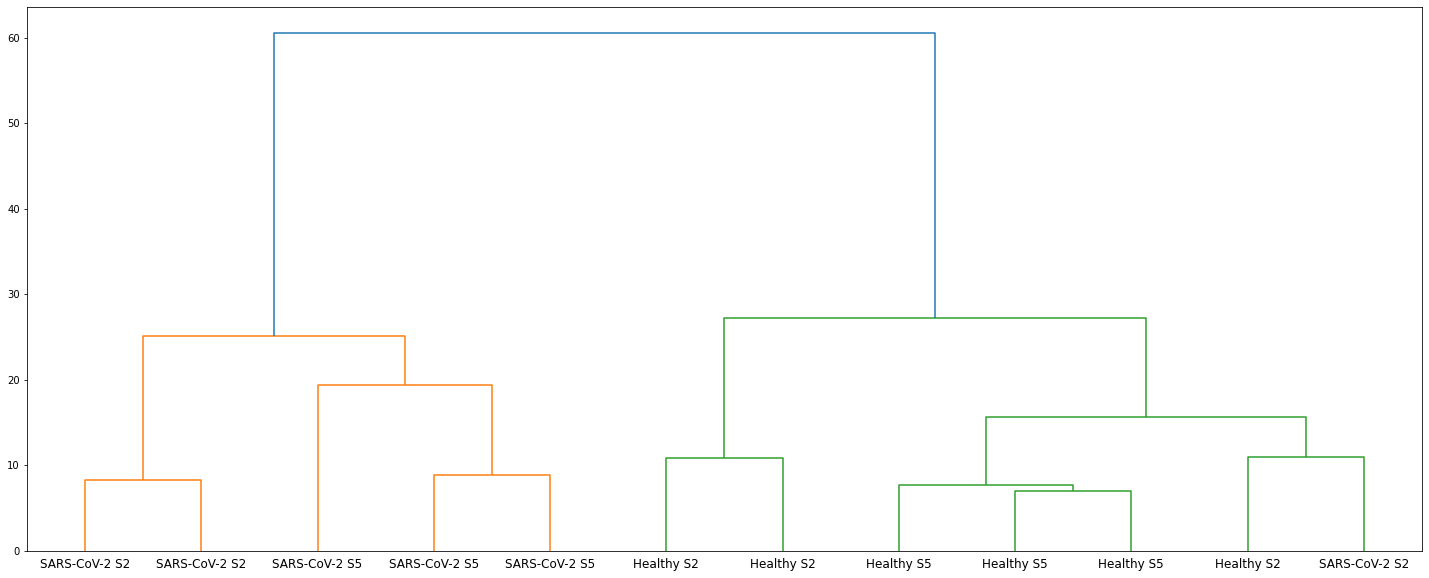

In [58]:
fig = plt.figure(figsize=(25, 10))
dendrogram = sch.dendrogram(sch.linkage(filtered_data.T, method="ward"), labels = list(['Healthy S2', 'Healthy S2', 'Healthy S2', 'SARS-CoV-2 S2', 'SARS-CoV-2 S2', 'SARS-CoV-2 S2', 'Healthy S5', 'Healthy S5', 'Healthy S5', 'SARS-CoV-2 S5', 'SARS-CoV-2 S5', 'SARS-CoV-2 S5']))
plt.show()

In [49]:
filtered_data.columns

Index(['Series2_A549_Mock_1', 'Series2_A549_Mock_2', 'Series2_A549_Mock_3',
       'Series2_A549_SARS-CoV-2_1', 'Series2_A549_SARS-CoV-2_2',
       'Series2_A549_SARS-CoV-2_3', 'Series5_A549_Mock_1',
       'Series5_A549_Mock_2', 'Series5_A549_Mock_3',
       'Series5_A549_SARS-CoV-2_1', 'Series5_A549_SARS-CoV-2_2',
       'Series5_A549_SARS-CoV-2_3'],
      dtype='object')

In [25]:
labels_columns = {}

models = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')
labels_columns['distance'] = models.fit_predict(filtered_data.T)

labels_true = [0 if col in columns_healthy else 1 for col in filtered_data.columns]

print("True: ", labels_true)
print("Predicted: ", labels_columns['distance'])
print(adjusted_rand_score(labels_true, labels_columns['distance']))

True:  [0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1]
Predicted:  [0 0 0 1 0 0 0 0 0 1 1 1]
0.39560439560439553
